In [2]:
import os
import sys
import math
import random

import glob

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from itertools import cycle

import re
import time
import pytz
from datetime import datetime

from scipy.ndimage.filters import gaussian_filter1d
from scipy.ndimage.filters import *

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from hyperopt import tpe, hp, STATUS_OK, Trials, space_eval
from hyperopt import fmin as hyfmin

# from sklearn.cluster import KMeans
# from sklearn.neighbors.kde import KernelDensity

from IPython.display import Image
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [3]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 25

plt.rcParams['text.usetex'] = True

plt.rcParams['axes.labelsize'] = 25
plt.rcParams['axes.labelweight'] = 'bold'
    
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markeredgewidth'] = 2

plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.labelsize'] = 25
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 1

plt.rcParams['savefig.dpi'] = 500

### Coordination System Conversion and Distance Computation

In [3]:
earthR = 6378137.0

def outOfChina(lat, lng):
    return not (72.004 <= lng <= 137.8347 and 0.8293 <= lat <= 55.8271)


def transform(x, y):
    xy = x * y
    absX = math.sqrt(abs(x))
    xPi = x * math.pi
    yPi = y * math.pi
    d = 20.0*math.sin(6.0*xPi) + 20.0*math.sin(2.0*xPi)

    lat = d
    lng = d

    lat += 20.0*math.sin(yPi) + 40.0*math.sin(yPi/3.0)
    lng += 20.0*math.sin(xPi) + 40.0*math.sin(xPi/3.0)

    lat += 160.0*math.sin(yPi/12.0) + 320*math.sin(yPi/30.0)
    lng += 150.0*math.sin(xPi/12.0) + 300.0*math.sin(xPi/30.0)

    lat *= 2.0 / 3.0
    lng *= 2.0 / 3.0

    lat += -100.0 + 2.0*x + 3.0*y + 0.2*y*y + 0.1*xy + 0.2*absX
    lng += 300.0 + x + 2.0*y + 0.1*x*x + 0.1*xy + 0.1*absX

    return lat, lng


def delta(lat, lng):
    ee = 0.00669342162296594323
    dLat, dLng = transform(lng-105.0, lat-35.0)
    radLat = lat / 180.0 * math.pi
    magic = math.sin(radLat)
    magic = 1 - ee * magic * magic
    sqrtMagic = math.sqrt(magic)
    dLat = (dLat * 180.0) / ((earthR * (1 - ee)) / (magic * sqrtMagic) * math.pi)
    dLng = (dLng * 180.0) / (earthR / sqrtMagic * math.cos(radLat) * math.pi)
    return dLat, dLng


def wgs2gcj(wgsLat, wgsLng):
    if outOfChina(wgsLat, wgsLng):
        return wgsLat, wgsLng
    else:
        dlat, dlng = delta(wgsLat, wgsLng)
        return wgsLat + dlat, wgsLng + dlng

def distance(latA, lngA, latB, lngB):
    pi180 = math.pi / 180
    arcLatA = latA * pi180
    arcLatB = latB * pi180
    x = (math.cos(arcLatA) * math.cos(arcLatB) *
         math.cos((lngA - lngB) * pi180))
    y = math.sin(arcLatA) * math.sin(arcLatB)
    s = x + y
    if s > 1:
        s = 1
    if s < -1:
        s = -1
    alpha = math.acos(s)
    distance = alpha * earthR
    return distance

def calculate_distance(lat1, lon1, lat2, lon2):
    earth_radius = 6371*1000  # m
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) *                math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = earth_radius * c
    return d

In [4]:
df_trips = pd.read_csv('gps20161201',names=['driver_id','order_id','timestamp','longitude','latitude'])
df_trips = df_trips.sort_values(by=['driver_id','order_id','timestamp']).reset_index(drop=True)

### Snapshot of the Trajectory Data (incl. highlighted region)

In [5]:
def highlighted_region(df_trips):
    '''
    Visualize the specific region with highlight trips that running on the north or south bound road
    '''
    ## reference locations are required to convert to GCJ
    lat1, lon1 = wgs2gcj(34.234, 108.9415)
    lat2, lon2 = wgs2gcj(34.241, 108.943)

    ## locations in dataset have been in GCJ
    lat, lon = df_trips.latitude, df_trips.longitude
    ind = (lat <= lat2) & (lat >= lat1) & (lon <= lon2) & (lon >= lon1)

    plt.figure(figsize=(20,10))
    plt.scatter(lon[ind],lat[ind],c='b',s=2)
    plt.plot([lon1, lon2, lon2, lon1, lon1],[lat1, lat1, lat2, lat2, lat1], lw=2, color='r')
    plt.xlim((lon[ind].min() - 0.001,lon[ind].max() + 0.001))
    plt.ylim((lat[ind].min() - 0.001, lat[ind].max() + 0.001))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    plt.vlines(x=108.94673, ymin=lat1, ymax=lat2, color='k')
    plt.vlines(x=108.94679, ymin=lat1, ymax=lat2, color='k')
    plt.vlines(x=108.94688, ymin=lat1, ymax=lat2, color='k')
    plt.vlines(x=108.94694, ymin=lat1, ymax=lat2, color='k')

def trajectory(driver_id, df_trips):
    trips = df_trips[df_trips['driver_id'] == driver_id]
    src_time, src_lat, src_lon = -1, -1, -1

    fig = plt.figure(figsize=(10, 5))
    orders = np.unique(trips['order_id'])
    ntrip = orders.shape[0]
    plt.title('Driver {0} runs {1} trips'.format(driver_id, ntrip))
    
    for order in orders:
        trip = trips[trips['order_id'] == order].sort_values(by=['timestamp'])
    
        t1, lat1, lon1, duration = -1, -1, -1, 0
        ts, speeds = [0], [0]
        for index, row in trip.iterrows():
            t, lat, lon = row.timestamp, row.latitude, row.longitude

            if t1 > -1:
                dt = t - t1
                duration += dt
                dist = calculate_distance(lat1,lon1,lat,lon)
                speeds.append(3.6*dist/dt)
                ts.append(duration)
            else:
                src_time, src_lat, src_lon = t, lat, lon

            t1, lat1, lon1 = t, lat, lon

        plt.plot(ts, speeds, color='b')
        dest_time = t1
        
    plt.xlabel('Duration (s)')
    plt.ylabel('Speed (km/h)')

    ## specify the timezone
    timestr1 = datetime.fromtimestamp(src_time, tz= pytz.timezone('Asia/Shanghai')).strftime("%H:%M:%S/%d")
    timestr2 = datetime.fromtimestamp(dest_time, tz= pytz.timezone('Asia/Shanghai')).strftime("%H:%M:%S/%d")
    print('Order {0}: {1} - {2}'.format(order, timestr1, timestr2))

In [96]:
driver_id = np.unique(df_trips['driver_id'])[3]
trajectory(driver_id, df_trips)

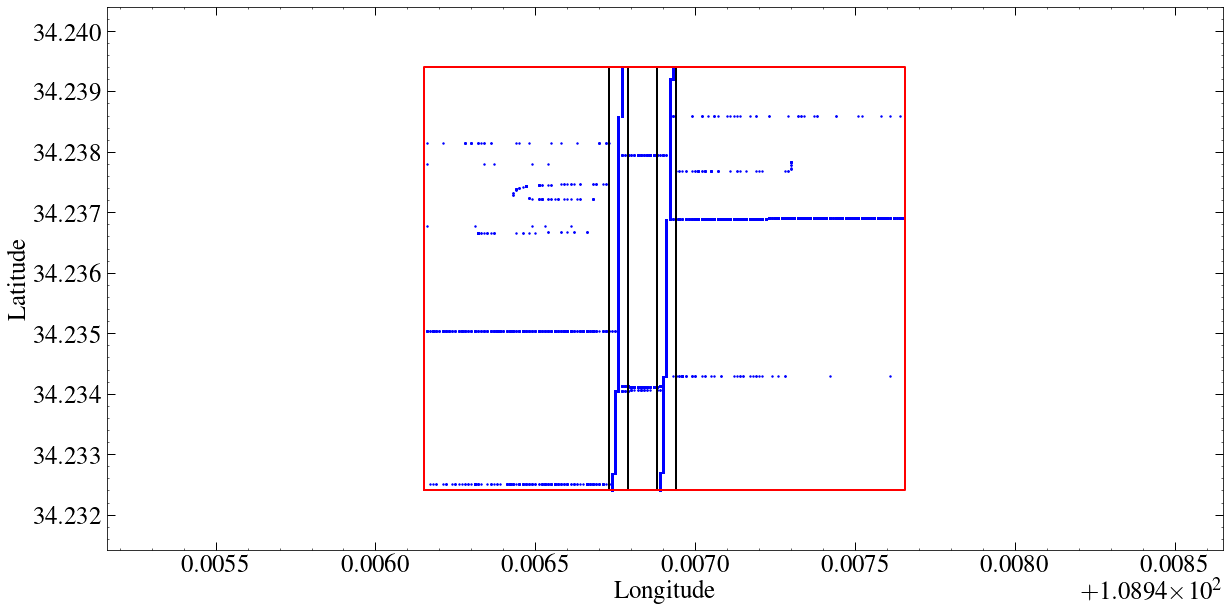

In [7]:
highlighted_region(df_trips)

In [1]:
def aligned_observations():
    '''
    Generate timestamp from string time format and align the time stamp w.r.t 00:00:00AM on the same day
    '''
    speed_north = pd.read_csv('Predictions_north.csv')
    speed_south = pd.read_csv('Predictions_south.csv')

    timestr = '20161201 {0}'

    timestamps_north = []
    for i in range(speed_north.shape[0]):
        timeline = speed_north.iloc[i].time
        stamp = datetime.strptime(timestr.format(timeline), '%Y%m%d %H:%M:%S %p').timestamp()
        if timeline.startswith('12') and timeline.endswith('AM'):
            timeline = '0' + timeline[2:]
            stamp = datetime.strptime(timestr.format(timeline), '%Y%m%d %H:%M:%S %p').timestamp()
        elif timeline.endswith('PM'):
            stamp += 12 * 3600

        if i == 0:
            ref = stamp

        timestamps_north.append(1480521605 + stamp - ref)

    timestamps_south = []
    for i in range(speed_south.shape[0]):
        timeline = speed_south.iloc[i].time
        stamp = datetime.strptime(timestr.format(timeline), '%Y%m%d %H:%M:%S').timestamp()
        if i == 0:
            ref = stamp
        timestamps_south.append(1480521604 + stamp - ref)

    timestamps_north = np.array(timestamps_north, dtype='int')
    timestamps_south = np.array(timestamps_south, dtype='int')

    speed_north['timestamp'] = timestamps_north
    speed_south['timestamp'] = timestamps_south
    
    ## reference timestamp
    ref_timestamp = datetime.strptime('20161201 00:00:00+0800',"%Y%m%d %H:%M:%S%z").timestamp()
    ## add timeoffset column for alignment and comparison
    speed_north['timeoffset'] = speed_north['timestamp'] - int(ref_timestamp)
    speed_south['timeoffset'] = speed_south['timestamp'] - int(ref_timestamp)
    return speed_north, speed_south

In [4]:
speed_north, speed_south = aligned_observations()

In [10]:
def visualize_observations(speed_north, speed_south):
    '''
    Visualize the observed speed data and where the observations are missing (in red)
    '''
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15, 8), sharex='all')
    missed_ind = speed_south.speed == 0
    ax1.scatter(speed_south[~missed_ind].timeoffset, speed_south[~missed_ind].speed,color='b')
    ax1.scatter(speed_south[missed_ind].timeoffset, speed_south[missed_ind].speed,color='r')

    missed_ind = speed_north.speed == 0
    ax2.scatter(speed_north[~missed_ind].timeoffset, speed_north[~missed_ind].speed,color='b')
    ax2.scatter(speed_north[missed_ind].timeoffset, speed_north[missed_ind].speed,color='r')

    ax2.set_xlabel('timestamp offset (s) w.r.t 00:00:00')
    ax1.set_ylabel('south speed (km/h)')
    ax2.set_ylabel('north speed (km/h)')

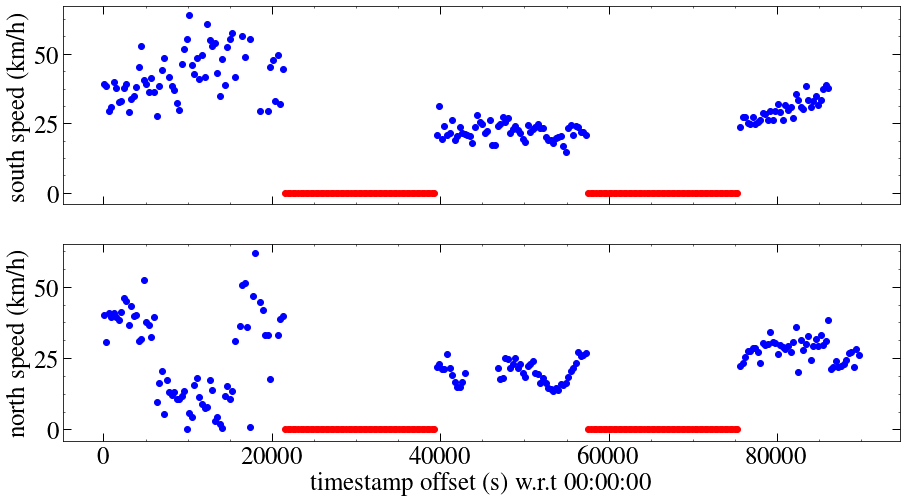

In [11]:
visualize_observations(speed_north, speed_south)

### Data Processing 
- Re-encoding drivers and orders w/ integers to reduce hard disk consumption
- Calculating timestamp offset w.r.t 00:00:00 of the same day to ease the computation

In [12]:
def reencoding(folders):
    '''
    Encode the driver_id and order_id with integers to save the space, while build a map to analyze
    all unique DiDi driver in the dataset. If the size is small, a possible idea is to analyze the
    driving behavior for each driver. Also, the timestamps are recalculated as offsets to 00:00:00AM.
    '''
    with open('drivers.csv', 'a') as fdrv, open('orders.csv', 'a') as ford:
        fdrv.write('driver,driver_id,date\n')
        ford.write('order,order_id,date\n')

        for folder in folders:
            for fnm in glob.glob(folder + '/gps*'):
                date = fnm[-8:]
                ref_timestamp = datetime.strptime('{} 00:00:00+0800'.format(date),"%Y%m%d %H:%M:%S%z").timestamp()

                df = pd.read_csv(fnm,names=['driver','order','timeoffset','longitude','latitude'])
                drivers = pd.Categorical(df.driver)
                dat = pd.DataFrame(data={'driver': drivers.codes, 'driver_id': df.driver})
                dat.drop_duplicates(inplace=True)
                dat.sort_values(by=['driver'],inplace=True)
                dat['date'] = date
                ## keep records of drivers (original driver ids and newly created integer ids)
                dat.to_csv(fdrv,index=False,header=False)
                
                fdrv.flush()
                os.fsync(fdrv.fileno())
                
                df.driver = drivers.codes
            
                orders = pd.Categorical(df.order)
                dat = pd.DataFrame(data={'order': orders.codes, 'order_id': df.order})
                dat.drop_duplicates(inplace=True)
                dat.sort_values(by=['order'],inplace=True)
                dat['date'] = date
                ## keep records of orders (original order ids and newly created integer ids)
                dat.to_csv(ford,index=False,header=False)
                
                ford.flush()
                os.fsync(ford.fileno())

                df.order = orders.codes
                
                ## calculate timeoffset, and keep recording trip entries: driver, order, timeoffset, longitude and latitude
                df.timeoffset -= ref_timestamp
                df.to_csv(date + '.csv',index=False)

- align realtime speed following the same rule as the observations: timeoffset w.r.t 00:00:00 of the same day

In [13]:
def align_all_realtime_speed():
    '''
    Align the truncated realtime speed of all trajectories that fall into the desired region w.r.t
    the time offset along both south and north bounding vehicles for all days considered in the competition
    data set (31 days in Oct., 30 days in Nov., and Dec. 1, 2016). 
    
    (1) The aligned speed will be used to produce a smoothed speed based on the historical speeds calculated 
    from the individual taxi drivers, and the basic smoothing techniques and advanced ones can be utilized 
    with the time offset difference to the refered intervals. 
    
    (2) The basic assumption is that history is repeatedly occurred, and an adjustment can be made based on the 
    extracted speeds for each day (overall trend to reflect the uncontrollable factors, such as weather or
    traffic accidents). 
    
    (3) Also, machine learning methods can be used to learn a regression model over the extracted individual 
    real time speed estimation of the known speed for certain time intervals, and then use the regression 
    model to predict the missing speeds.
    '''
    north_lon1, north_lon2 = 108.94688, 108.94694
    south_lon1, south_lon2 = 108.94673, 108.94679

    lat1, lon1 = wgs2gcj(34.234, 108.9415)
    lat2, lon2 = wgs2gcj(34.241, 108.943)

    for fname in glob.glob(base + '201612*.csv'):
        date = fname[-12:-4]
        ## align all trajectory data for each day
        with open('aligned_speeds/aligned_speed_{}.csv'.format(date),'a') as f:
            f.write('timeoffset,offsetdiff,speed,date,direct\n')

            time1 = time.time()
            df = pd.read_csv(fname)
            time2 = time.time()
            print('load data: {}s'.format(time2 - time1))

            time1 = time2
            # drop rows those are out-of-range
            df = df[df.latitude.between(lat1,lat2,inclusive=True) & df.longitude.between(south_lon1,north_lon2,inclusive=True)]
            time2 = time.time()
            print('filter loc: {}s'.format(time2 - time1))

            time1 = time2
            # sort rows based on driver, order and timeoffset
            df = df.sort_values(by=['driver','order','timeoffset']).reset_index(drop=True)
            time2 = time.time()
            print('sort data: {}s'.format(time2 - time1))

            time1 = time2

            lat, lon = df.latitude, df.longitude
            orders, timeoffsets = df.order, df.timeoffset

            for i in range(df.shape[0]-1):
                ind_ord = (orders[i]==orders[i+1])

                if ind_ord:
                    ## south bounding vehicles
                    if (south_lon1<=lon[i]<=south_lon2) and (south_lon1<=lon[i+1]<=south_lon2):
                        bias = 4
                        t1, t2 = timeoffsets[i:i+2]
                        speed = 3.6*calculate_distance(lat[i], lon[i], lat[i+1], lon[i+1])/(t2-t1)

                        ## interval id of current time in the evenly distributed interval set
                        ## alignment of the time offset
                        ind = int(np.rint((t1 - bias)/300))
                        t = bias + 300 * ind
                        f.write('{0},{1},{2},{3},{4}\n'.format(t, t1-t, speed, date, 'S'))

                    ## north bounding vehicles                
                    elif (north_lon1<=lon[i]<=north_lon2) and (north_lon1<=lon[i+1]<=north_lon2):
                        bias = 5
                        t1, t2 = timeoffsets[i:i+2]
                        speed = 3.6*calculate_distance(lat[i], lon[i], lat[i+1], lon[i+1])/(t2-t1)
                        ind = int(np.rint((t1 - bias)/300))
                        t = bias + 300 * ind
                        f.write('{0},{1},{2},{3},{4}\n'.format(t, t1-t, speed, date, 'N'))
                    else:
                        continue

                    # write instantly with no loss when unexpected events happen
                    f.flush()
                    os.fsync(f.fileno())

            time2 = time.time()
            print('calc data: {}s'.format(time2 - time1))

In [14]:
align_all_realtime_speed()

In [15]:
import multiprocessing as mlp

def parallel_align_all_realtime_speed():
    '''
    Align the truncated realtime speed of all trajectories that fall into the desired region w.r.t
    the time offset along both south and north bounding vehicles for all days considered in the competition
    data set (31 days in Oct., 30 days in Nov., and Dec. 1, 2016). 
    
    (1) The aligned speed will be used to produce a smoothed speed based on the historical speeds calculated 
    from the individual taxi drivers, and the basic smoothing techniques and advanced ones can be utilized 
    with the time offset difference to the refered intervals. 
    
    (2) The basic assumption is that history is repeatedly occurred, and an adjustment can be made based on the 
    extracted speeds for each day (overall trend to reflect the uncontrollable factors, such as weather or
    traffic accidents). 
    
    (3) Also, machine learning methods can be used to learn a regression model over the extracted individual 
    real time speed estimation of the known speed for certain time intervals, and then use the regression 
    model to predict the missing speeds.
    '''
    north_lon1, north_lon2 = 108.94688, 108.94694
    south_lon1, south_lon2 = 108.94673, 108.94679

    lat1, lon1 = wgs2gcj(34.234, 108.9415)
    lat2, lon2 = wgs2gcj(34.241, 108.943)
    
    ## number of tasks to be executed in parallel
    ncpu = mlp.cpu_count()
    pool = mlp.Pool(processes=ncpu)

    for fname in glob.glob('201*.csv'):
        date = fname[-12:-4]

        df = pd.read_csv(fname)
        df = df.sort_values(by=['driver','order','timeoffset']).reset_index(drop=True)
        
        lat, lon = df.latitude, df.longitude
        orders, timeoffsets = df.order, df.timeoffset

        bias = 4
        params = [(lat1,lat2,south_lon1,south_lon2,bias,date,'S',lat,lon,timeoffsets,orders,ncpu,i) for i in range(south_ind.shape[0]-1)]
#         params = [(lat1,lat2,south_lon1,south_lon2,bias,date,'S',lat,lon,timeoffsets,orders,ncpu,i) for i in range(1000-1)]
        ## task assignment
        pool.map(calc_realtime_speed, params)

        bias = 5
        params = [(lat1,lat2,north_lon1,north_lon2,bias,date,'N',lat,lon,timeoffsets,orders,ncpu,i) for i in range(north_ind.shape[0]-1)]
        ## task assignment
        pool.map(calc_realtime_speed, params)

def calc_realtime_speed(args):
    '''
    Embarrassed parallel computing task of real time speed
    '''
    lat1,lat2,lon1,lon2,bias,date,direction,lat,lon,timeoffsets,orders,ntask,i = args
    base = '/Users/chjiang/GitHub/its/'
    ## fall into the desired region
    if (lat1 <= lat[i] <= lat2) and (lon1 <= lon[i] <= lon2) and (orders[i] == orders[i+1]):
        t1, t2 = timeoffsets[i:i+2]
        speed = 3.6*calculate_distance(lat[i], lon[i], lat[i+1], lon[i+1])/(t2-t1)

        ## interval id of current time in the evenly distributed interval set
        ## alignment of the time offset
        ind = int(np.rint((t1 - bias)/300))
        t = bias + 300 * ind
        fid = i%ntask
        with open(base + 'aligned_speed_{}.csv'.format(fid), 'a') as f: 
            f.write('{0},{1},{2},{3},{4}\n'.format(t, t1-t, speed, date, direction))
            f.flush()
            os.fsync(f.fileno())

In [16]:
# parallel_align_all_realtime_speed()

### Evaluate RMSE for Each Day Based on Different Criterion (mean, smoothed)

In [17]:
def estimate_error(speed_truth, speed_estimated, date, rule='mean'):
    '''
    Compute the root mean square error of observed speeds (w/o the missing speeds)
    '''
    selected1 = speed_truth[speed_truth.speed > 0]

    speed_estimated.sort_values(by=['timeoffset'],inplace=True)
    selected2 = speed_estimated.loc[speed_estimated.timeoffset.isin(selected1.timeoffset)]
    
    if rule == 'mean':
        groups = selected2.groupby(by='timeoffset')['speed'].mean()
    elif rule == 'median':
        groups = selected2.groupby(by='timeoffset')['speed'].median()

    estimated = groups.values
    truth = selected1.loc[selected1.timeoffset.isin(groups.keys())].speed
    error = np.sqrt(sum((truth - estimated) ** 2) / truth.shape[0])
    
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20, 5), sharex='all')
    ax1.scatter(groups.keys(),estimated,color='b')
    ax2.scatter(groups.keys(),truth,color='b')

    missing = speed_truth[speed_truth.speed == 0]
    selected2 = speed_estimated.loc[speed_estimated.timeoffset.isin(missing.timeoffset)]
    
    if rule == 'mean':
        groups = selected2.groupby(by='timeoffset')['speed'].mean()
    elif rule == 'median':
        groups = selected2.groupby(by='timeoffset')['speed'].median()

    ax1.scatter(groups.keys(),groups.values,color='r')
    ax2.scatter(missing.timeoffset,missing.speed,color='r')
    
    ax1.set_title('{0}/rmse={1:.3f}'.format(date,error))
    
    ax2.set_xlabel('time offset (s)')
    ax1.set_ylabel('estimated')
    ax2.set_ylabel('ground truth')

In [18]:
## load aligned speeds of all days
dfs = [pd.read_csv(fname) for fname in glob.glob('aligned_speeds/aligned*.csv')]
df = pd.concat(dfs, ignore_index=True)

## specific day
# df = pd.concat([df, pd.read_csv('aligned_speed_20161201.csv')], ignore_index=True)

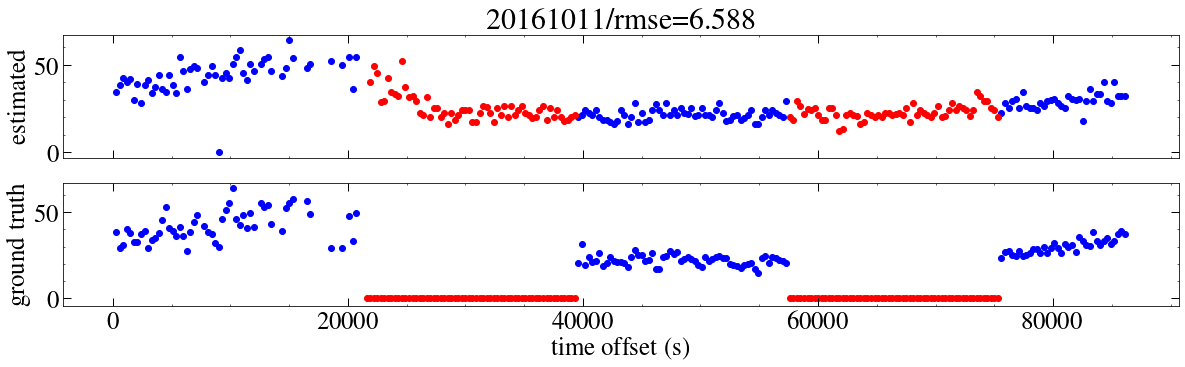

In [19]:
date = 20161011
rule='median'

aligned_south = df[(df.direct=='S') & (df.date == date)]
estimate_error(speed_south, aligned_south, date, rule)

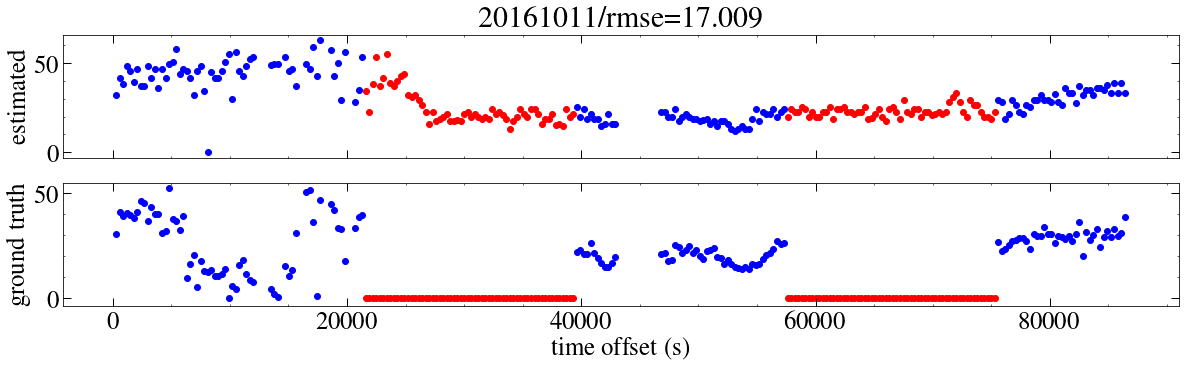

In [20]:
aligned_north = df[(df.direct=='N') & (df.date == date)]
estimate_error(speed_north, aligned_north, date, rule)

In [92]:
def moving_weights(sigma=60,radius=60*2.5):
    '''
    Gaussian smoothing weights
    '''
    p = np.polynomial.Polynomial([0, 0, -0.5 / (sigma * sigma)])
    t = np.arange(-radius, radius, 1)
    wt = np.exp(p(t), dtype=np.double)
    return wt 

def speed_smoothing(speed_estimated, wt):
    radius = wt.shape[0] // 2
    
    aligned_north.sort_values(by=['timeoffset'],inplace=True)
    groups = aligned_north.groupby(by='timeoffset')

    grp_speeds = groups['speed'].apply(lambda x: np.array(x)).values
    ## each time offset corresponds to multiple offset difference in [-radius, radius]
    grp_diffs = groups['offsetdiff'].apply(lambda x: np.array(x)).values

    smoothed_speeds = []
    for speeds, diffs in zip(grp_speeds, grp_diffs):
        indices = diffs.astype(int) + radius - 1
        selected_weight = wt[indices]
        smoothed_speeds.append(np.matmul(selected_weight,speeds)/sum(selected_weight))
    return list(groups.groups.keys()), smoothed_speeds

Text(0,0.5,'weight')

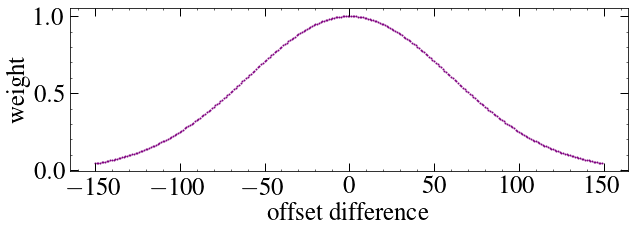

In [95]:
sigma, radius = 60, 60 * 2.5
wt = moving_weights(sigma,radius)

plt.figure(figsize=(10, 3))
plt.scatter(np.arange(-radius,radius,1),wt,color='purple',s=1)
plt.xlabel('offset difference')
plt.ylabel('weight')

In [ ]:
offsets, speeds = speed_smoothing(aligned_north,wt)
plt.figure(figsize=(15,3))
plt.scatter(offsets, speeds, c='b')

In [21]:
def get_dataset(df, speed_south, speed_north):
    '''
    Construct dataset for further analysis or applying machine learning methods
    '''
    dates = np.unique(df.date)
    for observations, direct, fname in zip([speed_south,speed_north], ['S', 'N'],['dataset_south.csv','dataset_north.csv']):
        entries = []
        for date in dates:
            estimations = df[(df.direct == direct) & (df.date == date)]
            estimations.sort_values(by=['timeoffset'],inplace=True)
            groups = estimations.groupby(by='timeoffset')['speed'].mean()
            time_2_speed = {int(k):v for k,v in zip(groups.keys(),groups.values)}
            
            entry = [] 
            for tos in observations.timeoffset:
                if tos in time_2_speed:
                    entry.append(time_2_speed[tos])
                else:
                    entry.append(0)

            entries.append(entry)
        entries = np.array(entries).T
        dataset = pd.DataFrame(entries,columns=dates)
        
        dataset['truth'] = list(observations.speed)
        dataset['timeoffset'] = list(observations.timeoffset)
        
        dataset.to_csv(fname, index=False)
        
def dataset_split(train_ratio=0.8,direction='N'):
    '''
    Split dataset into training set and testing set
    '''
    bounding = 'north' if direction == 'N' else 'south'
    dataset = pd.read_csv('dataset_{}.csv'.format(bounding))
    selected = dataset[dataset.truth > 0].reset_index(drop=True)

    means = selected.mean()
    stdvar = selected.std()
    zscored = (selected - means)/stdvar

    ninstances, nfeatures = selected.shape[0], dataset.shape[1] - 2
    ntrain = int(train_ratio * ninstances)
    ntest = ninstances - ntrain

    train_indices = np.random.choice(range(ninstances), ntrain)
    test_indices = np.where(~np.isin(np.array(range(ninstances)), train_indices))[0]

    xtrain = zscored.iloc[train_indices,:-2].reset_index(drop=True)
    ytrain = np.array(selected.iloc[train_indices,-2])

    xtest = zscored.iloc[test_indices,:-2].reset_index(drop=True)
    ytest = np.array(selected.iloc[test_indices,-2])
    return dataset, means, stdvar, xtrain, ytrain, xtest, ytest

def training(model,xtrain,ytrain,xtest,ytest):
    '''
    Training model with training and testing data sets
    '''
    model.fit(xtrain, ytrain)

    rmse_train = np.sqrt(mean_squared_error(ytrain, model.predict(xtrain)))
    rmse_test = np.sqrt(mean_squared_error(ytest, model.predict(xtest)))

    print('rmse train/test: {0:.4f}/{1:.4f}'.format(rmse_train,rmse_test))
    return model

def predict_speeds(dataset,means,stdvar,model,direction):
    '''
    Prediction performance (mixture of truths in blue and predictions in red)
    '''
    plt.figure(figsize=(20,5))

    selected = dataset[dataset.truth > 0]
    sc1 = plt.scatter(selected.timeoffset,selected.truth,c='b')

    normalized = (dataset - means)/stdvar
    xdata = normalized.iloc[:,:-2]
    ypred = model.predict(xdata)
    sc2 = plt.scatter(dataset.timeoffset,ypred,c='r')

    plt.title('South Bounding' if direction == 'S' else 'North Bounding',fontsize=25)
    plt.legend([sc1,sc2],['observed', 'predicted'], fontsize=25)
    plt.xlabel('time offset (s)')
    plt.ylabel('speed')
    
    return ypred

In [ ]:
get_dataset(df,speed_south,speed_north)

In [ ]:
def evaluate(regressor='gb'):
    '''
    Evaluate the performance of different regressors
    '''
    # gradient boosting
    if regressor == 'gb':
        params = {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.15, 
                  'random_state': 0, 'loss': 'ls'}
        model = GradientBoostingRegressor(**params)
    # random forest
    elif regressor == 'rf':
        params = {'n_estimators': 200, 'max_depth':3,'random_state':0}
        model = RandomForestRegressor(**params)
    # support vector
    elif regressor == 'sv':
        params = {'kernel':'rbf','gamma':0.2,'C':1e3,'epsilon':0.1}
        model = SVR(**params)

    for sign, bounding, speed_truth in zip(['N', 'S'],['north','south'],[speed_north,speed_south]):
        pred_fname = 'preds_{0}_{1}.csv'.format(bounding,regressor)
        
        # split dataset
        dataset, means, stdvar, xtrain, ytrain, xtest, ytest = dataset_split(train_ratio=0.8,direction=sign)
        # training model
        model = training(model,xtrain,ytrain,xtest,ytest)
        # make predictions
        speed_truth['preds']= predict_speeds(dataset,means,stdvar,model,direction=sign)
        # save prediction to local file
        speed_truth.to_csv(pred_fname, columns=['time','speed','preds'], index=False)

In [10]:
def evaluate_model(regressor, df_params, dataset, means, stdvar, xtrain, ytrain, xtest, ytest, sign):
    '''
    Evaluation the selected model on all dataset
    '''
    best = df_params[df_params.rmse == min(df_params.rmse)]

    params = {}
    if regressor == 'gb':
        params['n_estimators'] = best['n_estimators'].values[0]
        params['max_depth'] = best['max_depth'].values[0]
        params['learning_rate'] = best['learning_rate'].values[0]
        params['random_state'] = 0
        params['loss'] = 'ls'
        
        model = GradientBoostingRegressor(**params)
        
    elif regressor == 'rf':
        params['n_estimators'] = best['n_estimators'].values[0]
        params['max_depth'] = best['max_depth'].values[0]
        params['random_state'] = 0
        
        model = RandomForestRegressor(**params)
        
    elif regressor == 'sv':
        params['kernel'] = 'rbf'
        params['gamma'] = best['gamma'].values[0]
        params['C'] = best['C'].values[0]
        params['epsilon'] = best['epsilon'].values[0]

        model = SVR(**params)

    if sign == 'N':
        bounding = 'north'
        speed_truth = speed_north
    else:
        bounding = 'south'
        speed_truth = speed_south

    pred_fname = 'preds_{0}_{1}.csv'.format(bounding,regressor)
    
    model = training(model,xtrain,ytrain,xtest,ytest)
    # make predictions
    speed_truth['preds']= predict_speeds(dataset,means,stdvar,model,direction=sign)
    
    xdata = pd.concat([xtrain,xtest])
    ydata = np.concatenate([ytrain,ytest])
    model.predict(xdata)
    rmse = np.sqrt(mean_squared_error(ydata, model.predict(xdata)))
    print('rmse all: {0:.4f}'.format(rmse))

    # save prediction to local file
    speed_truth.to_csv(pred_fname, columns=['time','speed','preds'], index=False)

mse train/test: 0.6879/10.5283
mse train/test: 0.0005/6.8539


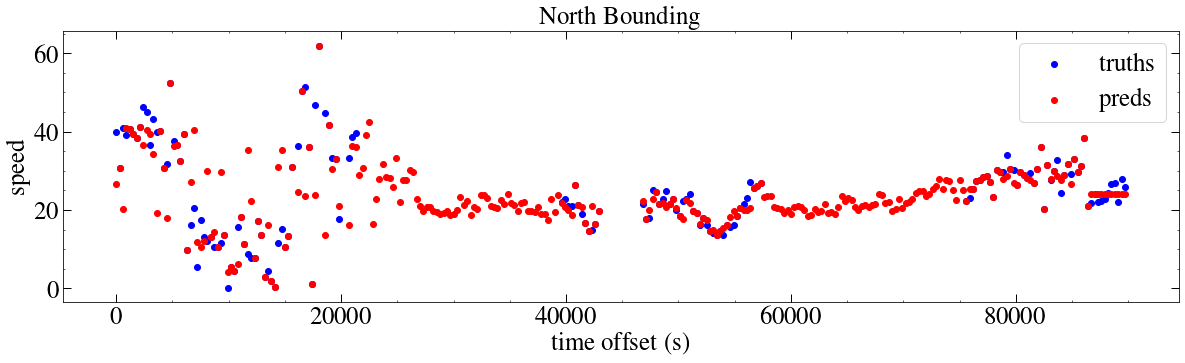

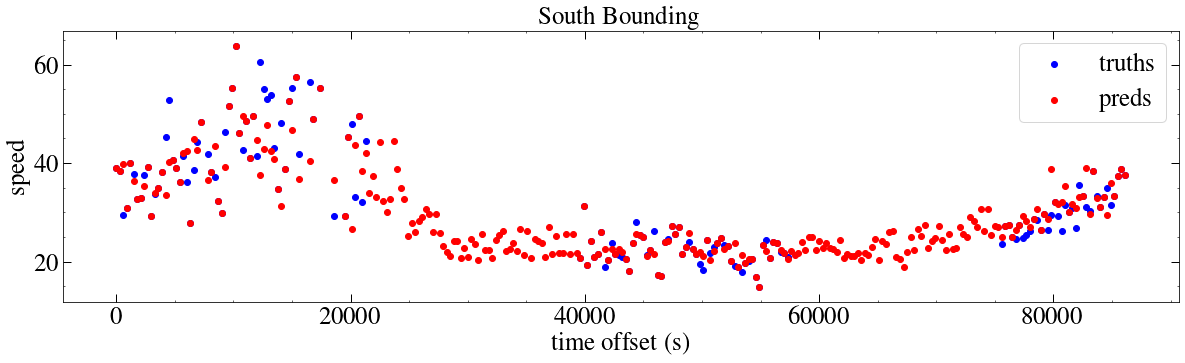

In [529]:
evaluate(regressor='gb')

mse train/test: 3.8038/10.2209
mse train/test: 2.6750/5.3876


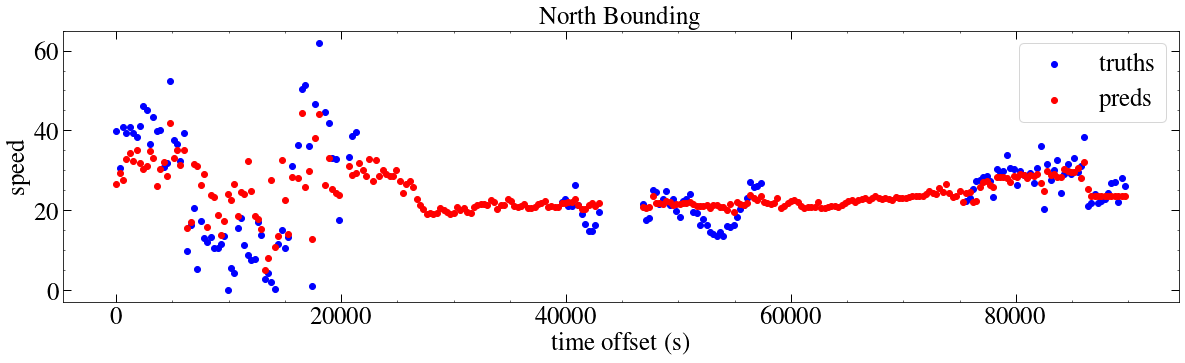

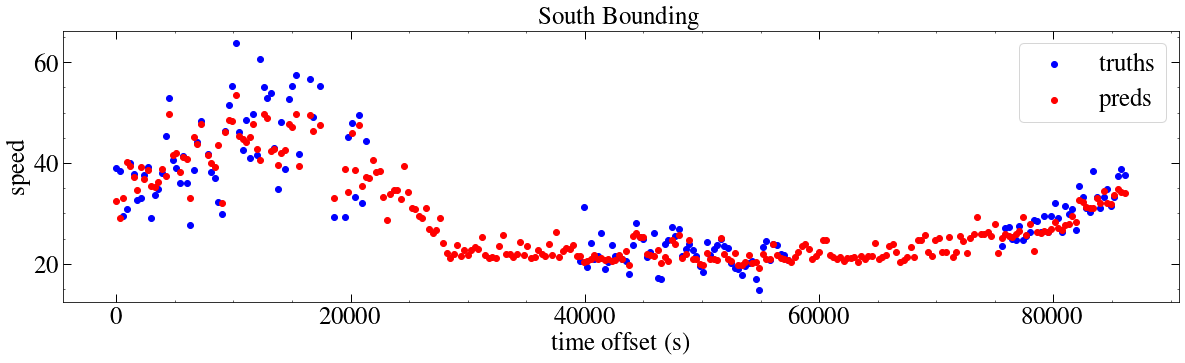

In [518]:
evaluate(regressor='rf')

mse train/test: 0.5604/10.3725
mse train/test: 0.0996/7.5489


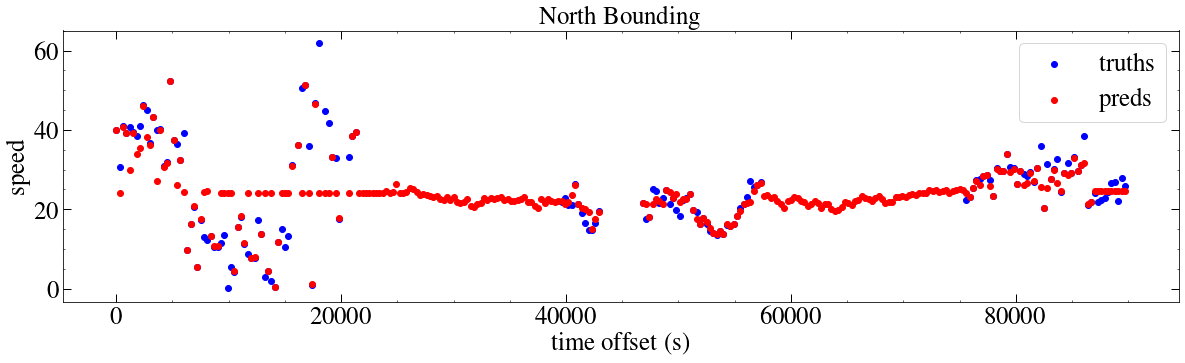

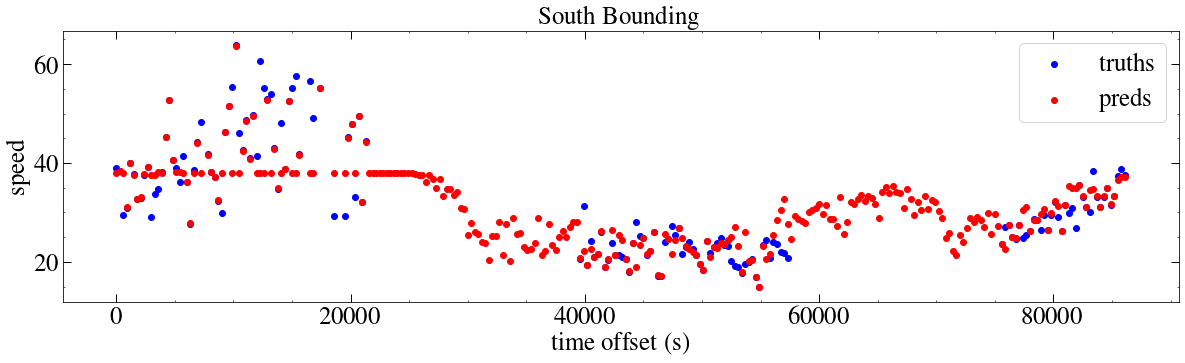

In [543]:
evaluate(regressor='sv')

### Hyper-parameter Tuning

In [79]:
def hyp_search(xtrain, ytrain, regressor='gb', numsamples=1000, direction='north'):
    '''
    Hyper optimization
    '''
    fname = 'params_{0}_{1}.csv'.format(regressor, direction)

    params_names = {'gb': ['n_estimators','max_depth','learning_rate'],
                   'rf': ['n_estimators','max_depth'],
                   'sv': ['gamma','C', 'epsilon']}
    
    if not os.path.exists(fname):
        ostream = open(fname, 'a')
        ostream.write(','.join(params_names[regressor]) + ',rmse\n')
        ostream.flush()
        os.fsync(ostream.fileno())
    else:
        ostream = open(fname, 'a')

    space = {}
    if regressor == 'gb':
        space['n_estimators'] = 60 + 20 * hp.randint('n_estimators', 12)
        space['max_depth'] = hp.choice('max_depth', [2, 3, 4])
        space['learning_rate'] = hp.uniform('learning_rate', 0.05,0.2)
    elif regressor == 'rf':
        space['n_estimators'] = 60 + 20 * hp.randint('n_estimators', 12)
        space['max_depth'] = hp.choice('max_depth', [2, 3, 4])
    elif regressor == 'sv':
        space['gamma'] = hp.uniform('gamma',0.1,100)
        space['C'] = hp.uniform('C', 1e1, 1e3)
        space['epsilon'] = hp.uniform('epsilon', 0.1, 0.5)

    num_params = len(space)
    re = ','.join(['{' + str(i) + '}' for i in range(num_params)])

    def query(params):
        if regressor in ['gb','rf']:
            n_estimators, max_depth = params['n_estimators'], params['max_depth']
            params['random_state'] = 0
            if regressor == 'gb':
                params['loss'] = 'ls'
                learning_rate = params['learning_rate']
                model = GradientBoostingRegressor(**params)
                mnm = re.format(n_estimators, max_depth, learning_rate)
            else:
                model = RandomForestRegressor(**params)
                mnm = re.format(n_estimators, max_depth)
        else:
            gamma, C, epsilon = params['gamma'], params['C'], params['epsilon']
            params['kernel'] = 'rbf'
            model = SVR(**params)
            mnm = re.format(gamma,C,epsilon)
        
        ## training and evaluate the prediction error
        # model.fit(xtrain, ytrain)
        # rmse_train = np.sqrt(mean_squared_error(ytrain, model.predict(xtrain)))

        # 10 fold cross validation
        rmse_train = np.sqrt(-cross_val_score(model,xtrain,ytrain,scoring='mean_squared_error',cv=10,n_jobs=3).mean())

        ostream.write(mnm + ',' + str(rmse_train) + '\n')
        ostream.flush()
        os.fsync(ostream.fileno())

        return {'loss': rmse_train, 'status': STATUS_OK}

    hyfmin(query, space, algo=tpe.suggest, max_evals=numsamples, trials=Trials())
    ostream.close()

In [34]:
dataset, means, stdvar, xtrain, ytrain, xtest, ytest = dataset_split(train_ratio=0.8,direction='N')

mse train/test: 0.5726/9.9244


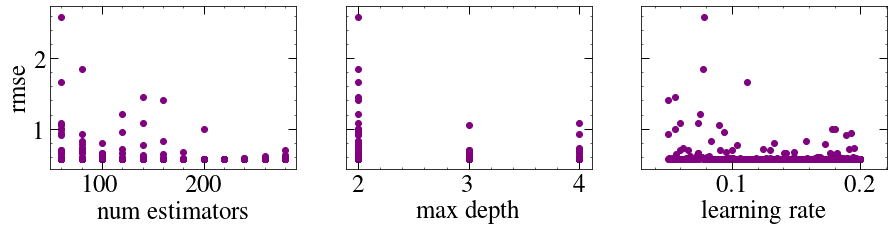

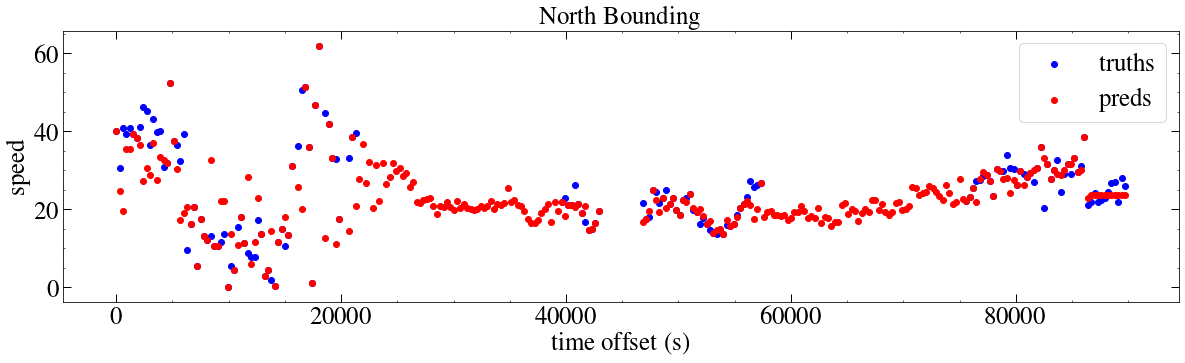

In [593]:
regressor, direction = 'gb', 'north'
hyp_search(xtrain, ytrain, regressor, numsamples=1000, direction=direction)
parameters = pd.read_csv('params_{0}_{1}.csv'.format(regressor,direction))

################### parameters ####################################
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3),sharey='all')
ax1.scatter(parameters['n_estimators'],parameters['rmse'],c='purple')
ax1.set_xlabel('num estimators')
ax1.set_ylabel('rmse')

ax2.scatter(parameters['max_depth'],parameters['rmse'],c='purple')
ax2.set_xlabel('max depth')

ax3.scatter(parameters['learning_rate'],parameters['rmse'],c='purple')
ax3.set_xlabel('learning rate')
###################################################################

df_params = parameters[parameters.rmse == min(parameters.rmse)]
evaluate_model(regressor, df_params, dataset, means, stdvar, xtrain, ytrain, xtest, ytest, 'N')

mse train/test: 3.8408/9.5828


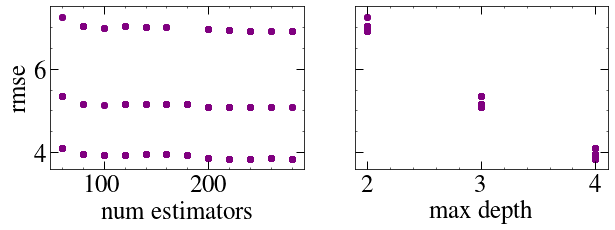

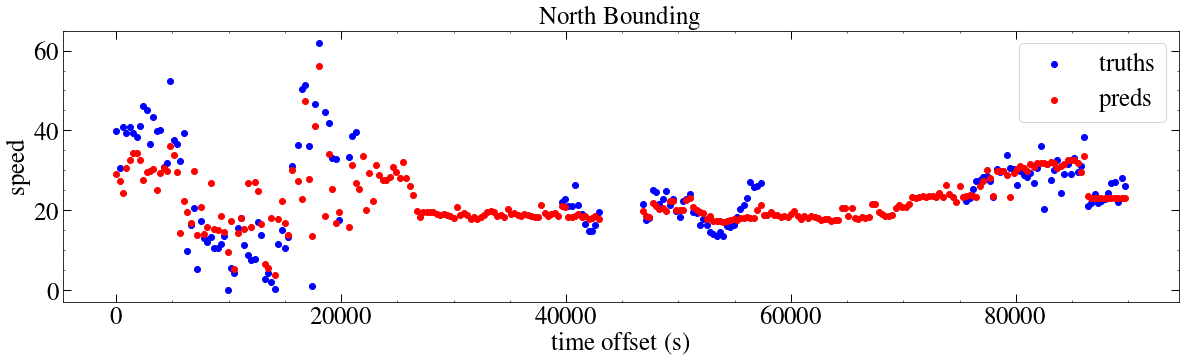

In [603]:
regressor, direction = 'rf', 'north'
hyp_search(xtrain, ytrain, regressor, numsamples=1000, direction=direction)
parameters = pd.read_csv('params_{0}_{1}.csv'.format(regressor,direction))

################### parameters ####################################
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3),sharey='all')
ax1.scatter(parameters['n_estimators'],parameters['rmse'],c='purple')
ax1.set_xlabel('num estimators')
ax1.set_ylabel('rmse')

ax2.scatter(parameters['max_depth'],parameters['rmse'],c='purple')
ax2.set_xlabel('max depth')

###################################################################

df_params = parameters[parameters.rmse == min(parameters.rmse)]
evaluate_model(regressor, df_params, dataset, means, stdvar, xtrain, ytrain, xtest, ytest, 'N')

mse train/test: 1.0163/35.4421


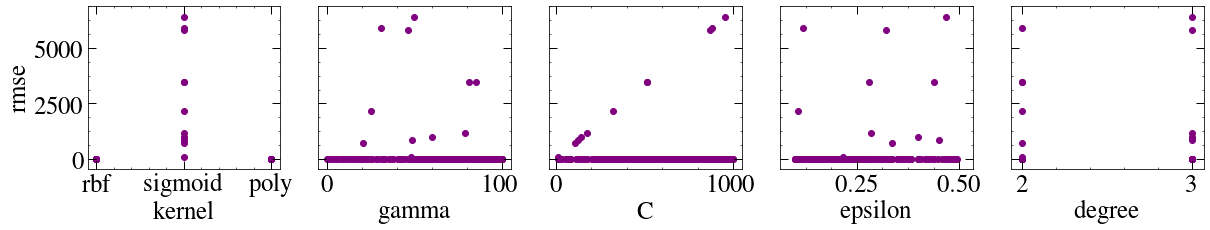

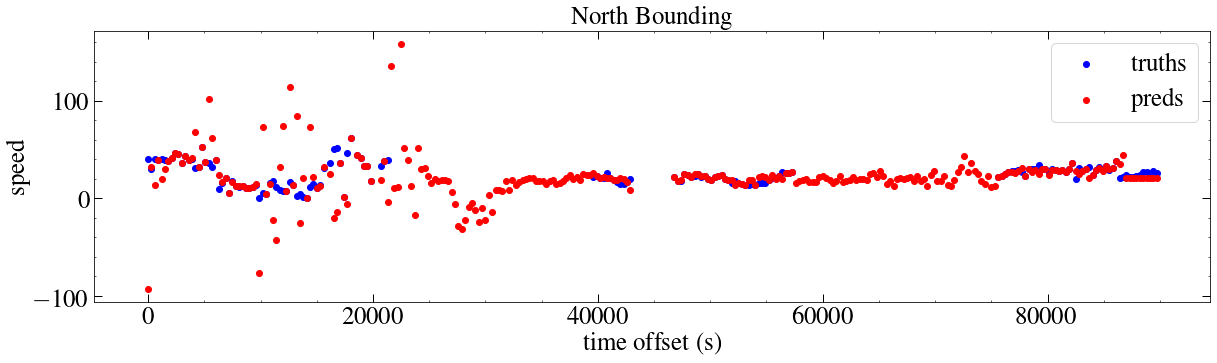

In [36]:
regressor,direction,sign = 'sv', 'north', 'N'

hyp_search(xtrain, ytrain, regressor, numsamples=100, direction=direction)
parameters = pd.read_csv('params_{0}_{1}.csv'.format(regressor,direction))

################### parameters ####################################
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,3),sharey='all')

ax1.scatter(parameters['gamma'],parameters['rmse'],c='purple')
ax1.set_xlabel('gamma')
ax1.set_ylabel('rmse')

ax2.scatter(parameters['C'],parameters['rmse'],c='purple')
ax2.set_xlabel('C')

ax3.scatter(parameters['epsilon'],parameters['rmse'],c='purple')
ax3.set_xlabel('epsilon')
################################################################
df_params = parameters[parameters.rmse == min(parameters.rmse)]
evaluate_model(regressor, df_params, dataset, means, stdvar, xtrain, ytrain, xtest, ytest, sign)

### Evaluation of performance and experimental comparisons

In [8]:
def hyper_search_evaluation(dataset, means, stdvar, xtrain, ytrain, xtest, ytest, sign='N'):
    '''
    Hyper-searching and evaluation altogether
    '''
    direction = 'south' if sign == 'S' else 'north'
    numsamples = 1000
    for regressor in ['gb','rf','sv']:
        hyp_search(xtrain, ytrain, regressor, numsamples, direction=direction)
        parameters = pd.read_csv('params_{0}_{1}.csv'.format(regressor,direction))

       ################### parameters #################################### 
        if regressor == 'gb':
            fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,3),sharey='all')
            ax1.scatter(parameters['n_estimators'],parameters['rmse'],c='purple')
            ax1.set_xlabel('num estimators')
            ax1.set_ylabel('rmse')

            ax2.scatter(parameters['max_depth'],parameters['rmse'],c='purple')
            ax2.set_xlabel('max depth')

            ax3.scatter(parameters['learning_rate'],parameters['rmse'],c='purple')
            ax3.set_xlabel('learning rate')
        elif regressor == 'rf':
            fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,3),sharey='all')
            ax1.scatter(parameters['n_estimators'],parameters['rmse'],c='purple')
            ax1.set_xlabel('num estimators')
            ax1.set_ylabel('rmse')

            ax2.scatter(parameters['max_depth'],parameters['rmse'],c='purple')
            ax2.set_xlabel('max depth')
        elif regressor == 'sv':
            fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(20,3),sharey='all')
            ax1.scatter(parameters['gamma'],parameters['rmse'],c='purple')
            ax1.set_xlabel('gamma')
            ax1.set_ylabel('rmse')

            ax2.scatter(parameters['C'],parameters['rmse'],c='purple')
            ax2.set_xlabel('C')

            ax3.scatter(parameters['epsilon'],parameters['rmse'],c='purple')
            ax3.set_xlabel('epsilon')
        ###################################################################

        df_params = parameters[parameters.rmse == min(parameters.rmse)]
        evaluate_model(regressor, df_params, dataset, means, stdvar, xtrain, ytrain, xtest, ytest, sign)

rmse train/test: 0.5480/9.4089
rmse all: 5.5956
rmse train/test: 4.1948/9.9148
rmse all: 6.7796
rmse train/test: 0.7623/10.2497
rmse all: 6.1076
rmse train/test: 0.0836/6.7496
rmse all: 4.0240
rmse train/test: 2.3577/6.0163
rmse all: 4.0553
rmse train/test: 0.1187/6.2826
rmse all: 3.7463


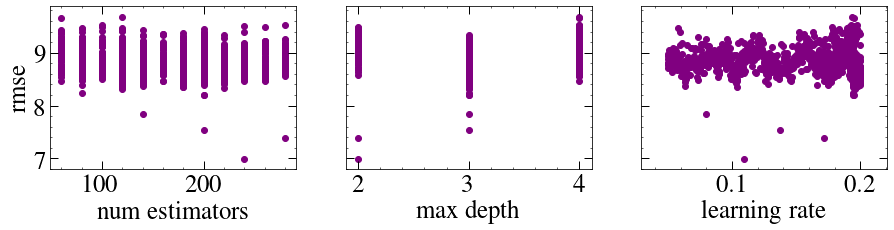

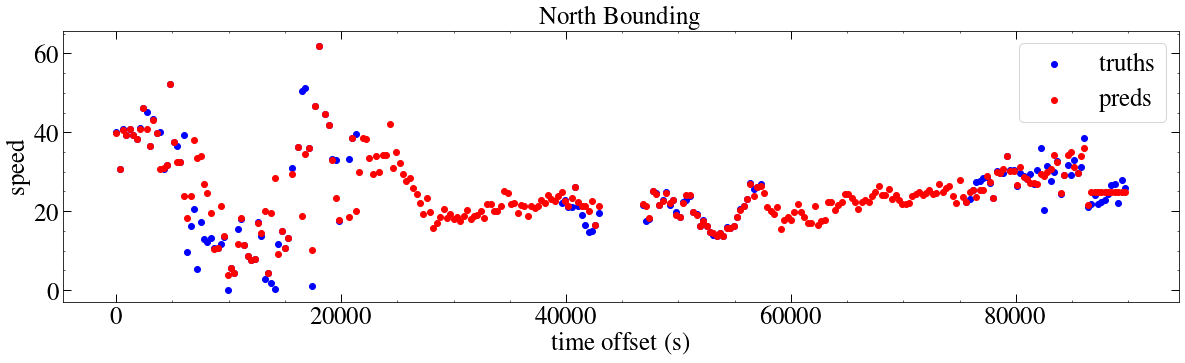

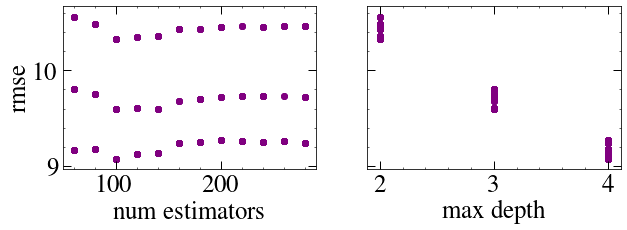

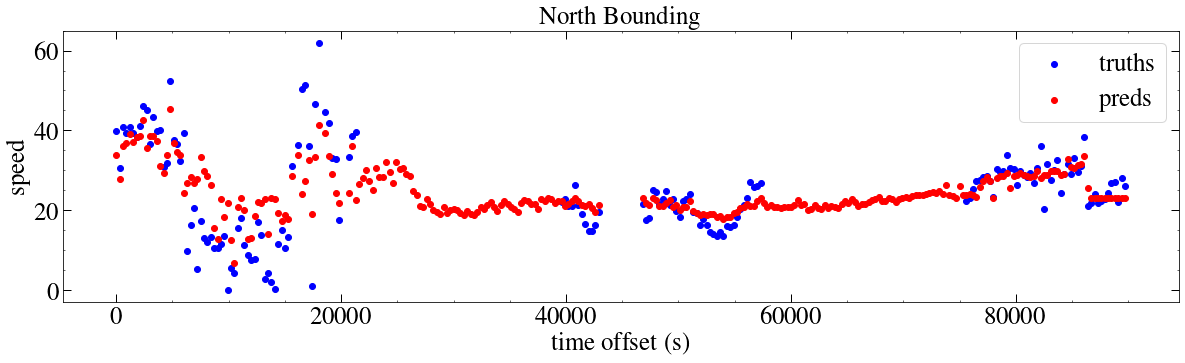

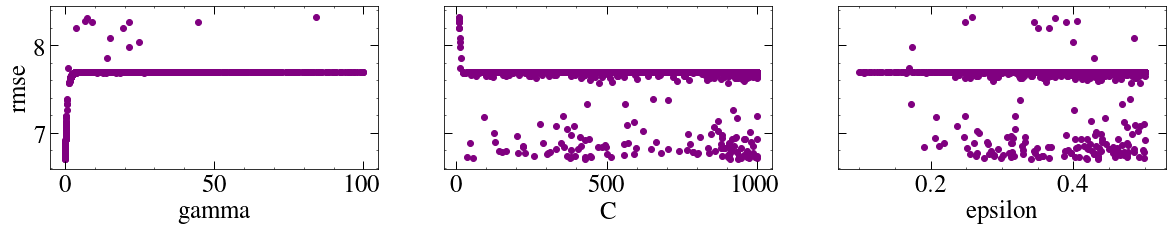

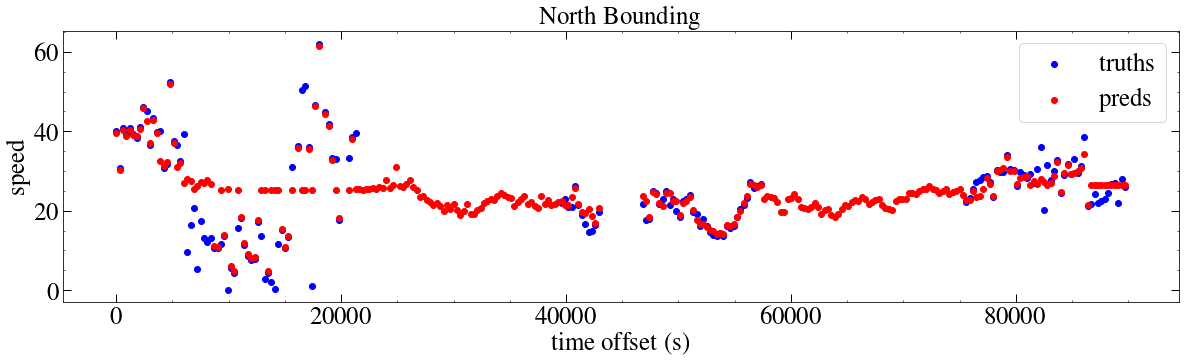

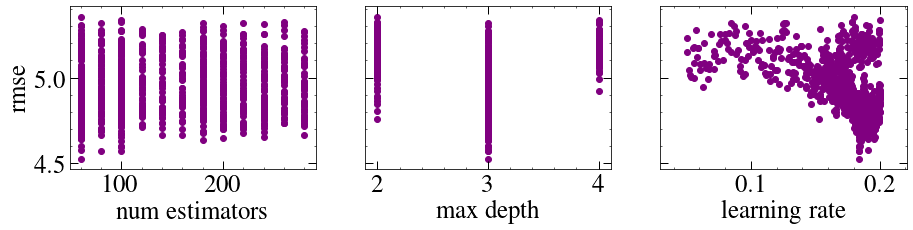

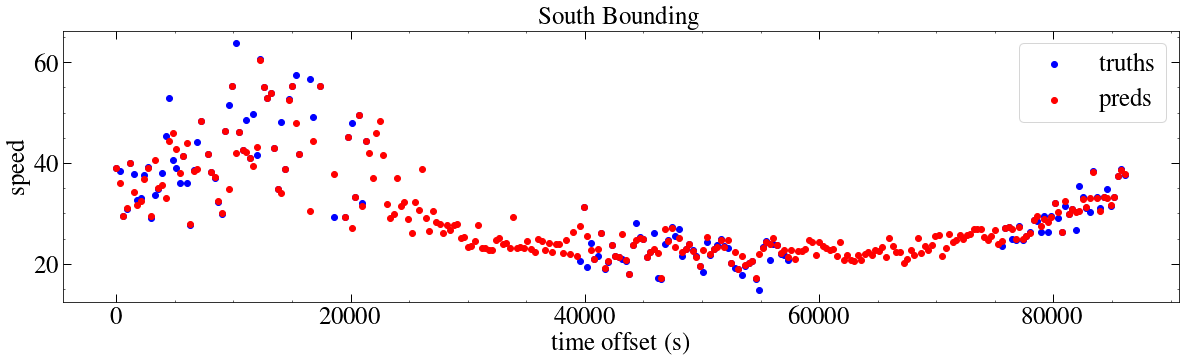

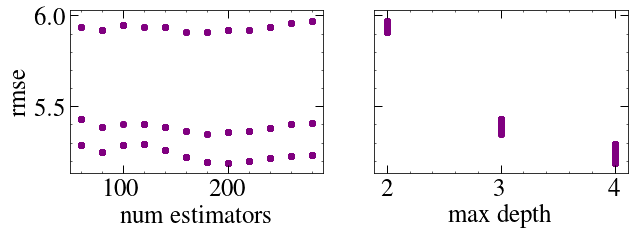

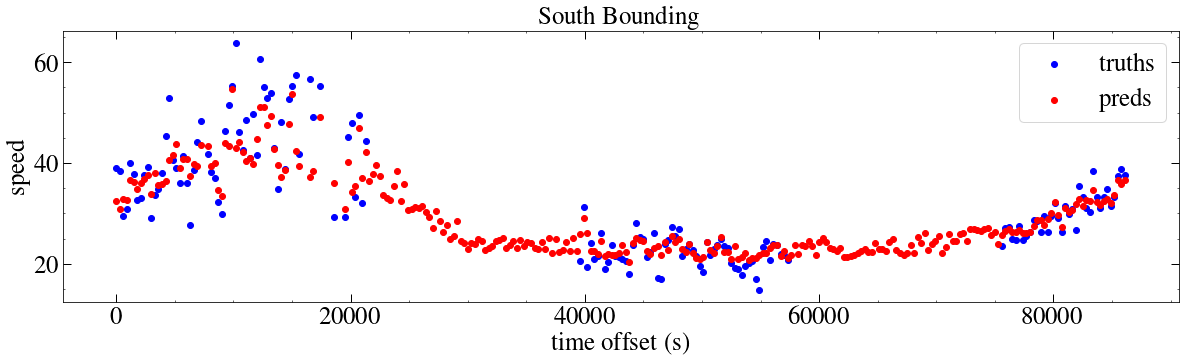

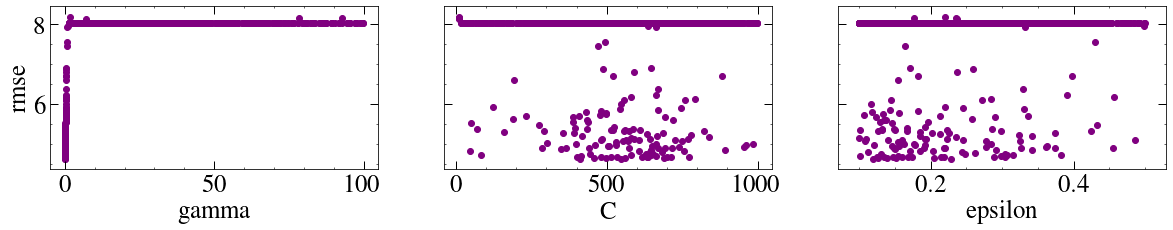

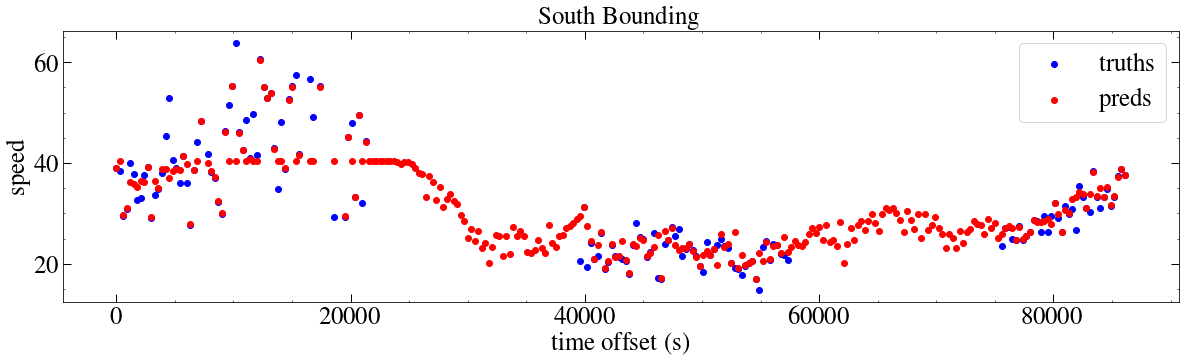

In [86]:
sign = 'N'
dataset, means, stdvar, xtrain, ytrain, xtest, ytest = dataset_split(train_ratio=0.8,direction=sign)
hyper_search_evaluation(dataset, means, stdvar, xtrain, ytrain, xtest, ytest, sign)

sign = 'S'
dataset, means, stdvar, xtrain, ytrain, xtest, ytest = dataset_split(train_ratio=0.8,direction=sign)
hyper_search_evaluation(dataset, means, stdvar, xtrain, ytrain, xtest, ytest, sign)

In [ ]:
# rmse train/test: 0.5480/9.4089
# rmse all: 5.5956
# rmse train/test: 4.1948/9.9148
# rmse all: 6.7796
# rmse train/test: 0.7623/10.2497
# rmse all: 6.1076
# rmse train/test: 0.0836/6.7496
# rmse all: 4.0240
# rmse train/test: 2.3577/6.0163
# rmse all: 4.0553
# rmse train/test: 0.1187/6.2826
# rmse all: 3.7463

In [89]:
regressor, direction = 'gb', 'south'
parameters = pd.read_csv('params_{0}_{1}.csv'.format(regressor,direction))
parameters[parameters.rmse == parameters.rmse.min()]

,n_estimators,max_depth,learning_rate,rmse
763,60,3,0.184038,4.522774


rmse train/test: 0.5325/11.6584
rmse all: 7.1347
rmse train/test: 3.5887/11.3917
rmse all: 7.5169
rmse train/test: 0.6461/10.6863
rmse all: 6.5483
rmse train/test: 0.1050/7.6052
rmse all: 4.5753
rmse train/test: 2.1311/7.0464
rmse all: 4.5676
rmse train/test: 0.1186/6.5258
rmse all: 3.9265


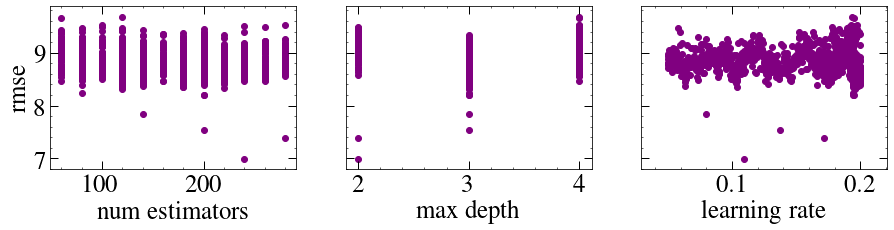

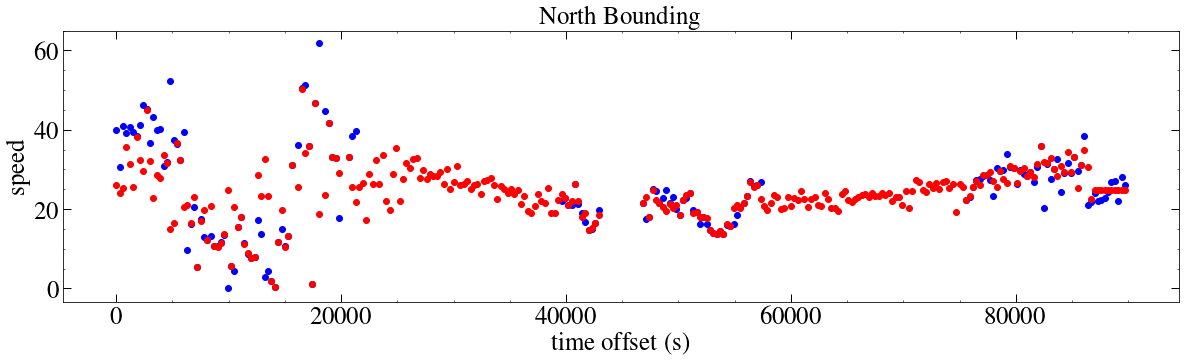

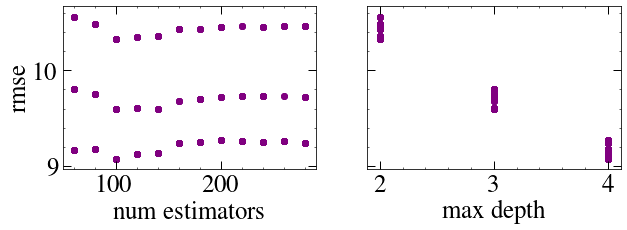

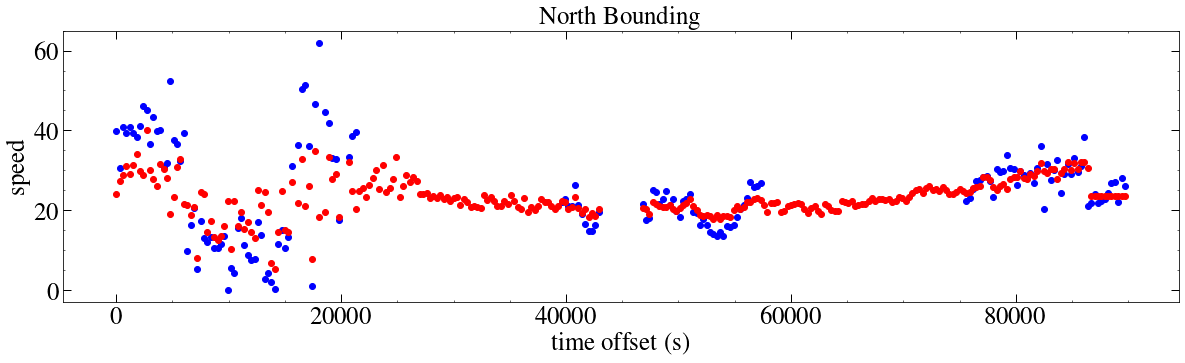

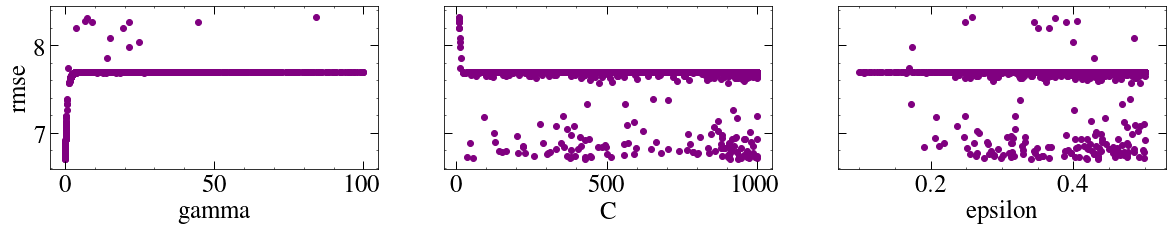

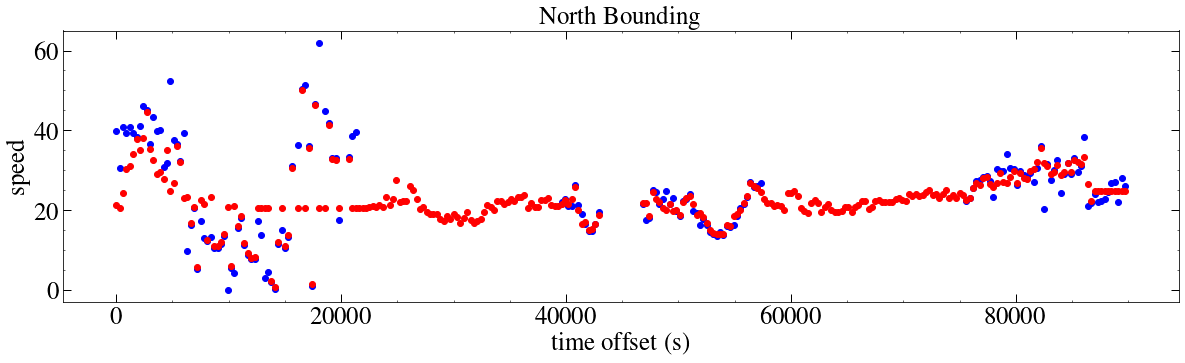

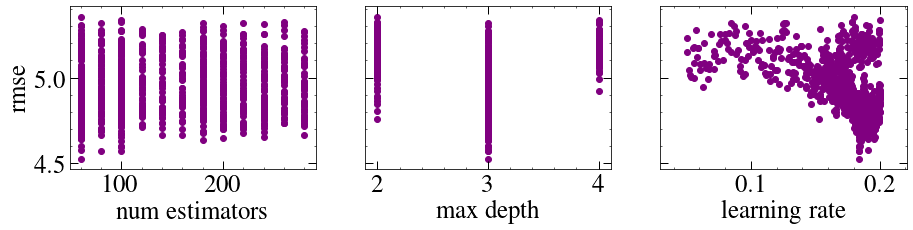

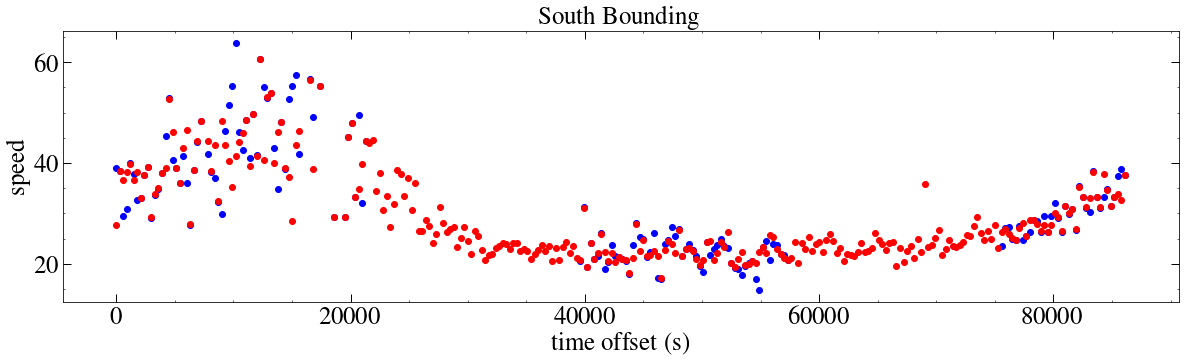

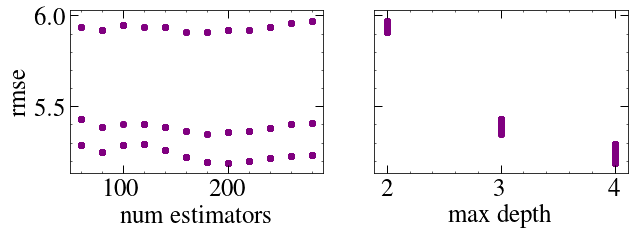

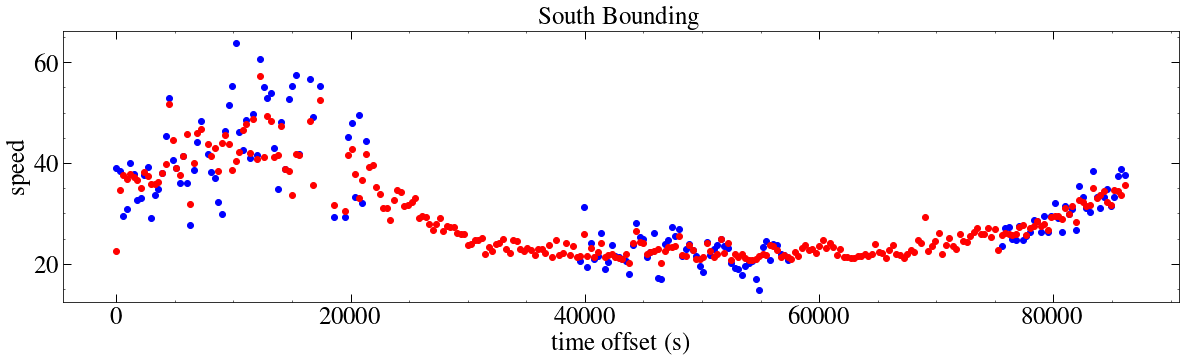

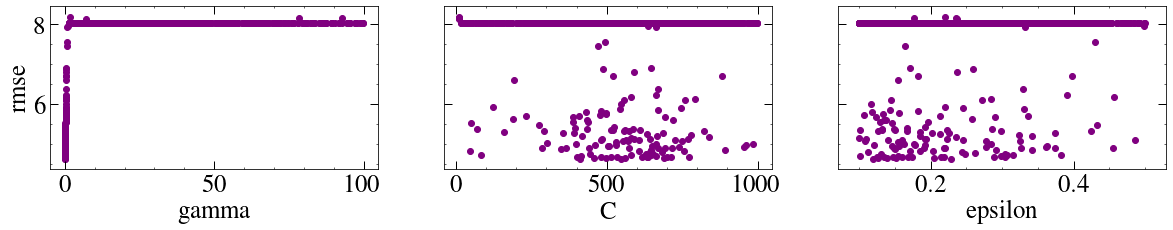

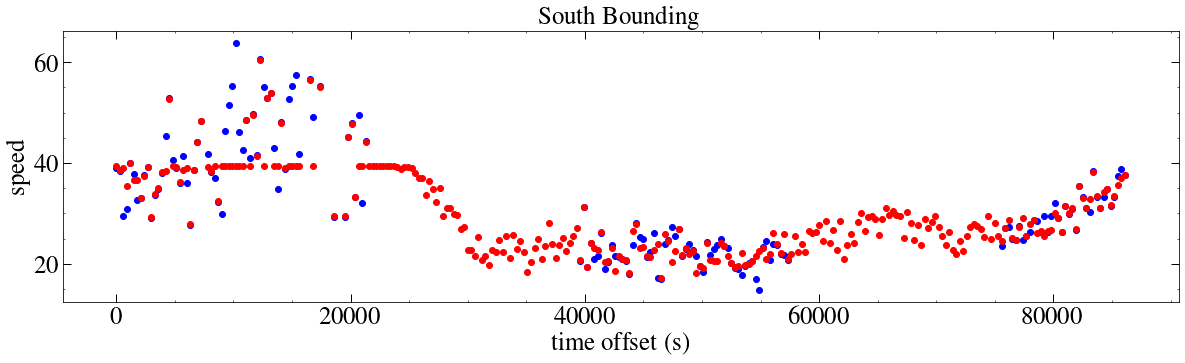

In [22]:
sign = 'N'
dataset, means, stdvar, xtrain, ytrain, xtest, ytest = dataset_split(train_ratio=0.8,direction=sign)
hyper_search_evaluation(dataset, means, stdvar, xtrain, ytrain, xtest, ytest, sign)

sign = 'S'
dataset, means, stdvar, xtrain, ytrain, xtest, ytest = dataset_split(train_ratio=0.8,direction=sign)
hyper_search_evaluation(dataset, means, stdvar, xtrain, ytrain, xtest, ytest, sign)

In [93]:
def evaluate_model_cv(sign):
    '''
    Evaluation the selected model on all dataset: k-fold
    '''
    direction = 'south' if sign == 'S' else 'north'
    numsamples = 1000
    
    submission_avg, sum_inversed_error_weight = None, 0
    
    for regressor, submission in zip(['gb','rf','sv'], range(1,4)):
        parameters = pd.read_csv('params_{0}_{1}.csv'.format(regressor,direction))
        df_params = parameters[parameters.rmse == min(parameters.rmse)]

        best = df_params[df_params.rmse == min(df_params.rmse)]

        params = {}
        if regressor == 'gb':
            params['n_estimators'] = best['n_estimators'].values[0]
            params['max_depth'] = best['max_depth'].values[0]
            params['learning_rate'] = best['learning_rate'].values[0]
            params['random_state'] = 0
            params['loss'] = 'ls'

            model = GradientBoostingRegressor(**params)

        elif regressor == 'rf':
            params['n_estimators'] = best['n_estimators'].values[0]
            params['max_depth'] = best['max_depth'].values[0]
            params['random_state'] = 0

            model = RandomForestRegressor(**params)

        elif regressor == 'sv':
            params['kernel'] = 'rbf'
            params['gamma'] = best['gamma'].values[0]
            params['C'] = best['C'].values[0]
            params['epsilon'] = best['epsilon'].values[0]

            model = SVR(**params)

        if sign == 'N':
            bounding = 'north'
            speed_truth = speed_north
        else:
            bounding = 'south'
            speed_truth = speed_south

        pred_fname = 'Predictions_{0}_{1}.csv'.format(bounding,submission)

        kcv, pred_cv, mean_rmse = 10, [], 0
        for _ in range(kcv):
            dataset, means, stdvar, xtrain, ytrain, xtest, ytest = dataset_split(train_ratio=0.8,direction=sign)
            model.fit(xtrain,ytrain)

            normalized = (dataset - means)/stdvar
            xdata = normalized.iloc[:,:-2]
            ypred = model.predict(xdata)

            if len(pred_cv) == 0:
                pred_cv = ypred
            else:
                pred_cv += ypred

            # prediction over all observed data
            xdata = pd.concat([xtrain,xtest])
            ydata = np.concatenate([ytrain,ytest])
            pred = model.predict(xdata)
            rmse = np.sqrt(mean_squared_error(pred,ydata))
            mean_rmse += rmse

        pred_cv /= kcv
        mean_rmse /= kcv

        speed_truth['predicted']= pred_cv
        print('rmse all: {0:.4f}'.format(mean_rmse))
        
        # rename the column name
        speed_truth=speed_truth.rename(index=str, columns={'speed':'observed'})
        # save prediction to local file
        speed_truth.to_csv(pred_fname, columns=['time','observed','predicted'], index=False)

        if submission == 1:
            submission_avg = pred_cv / mean_rmse
        else:
            submission_avg += pred_cv / mean_rmse

        sum_inversed_error_weight += (1.0/mean_rmse)
    
    ## average of the predictions of the above models: gb, rf and sv
    ## weights are inversed rmses
    speed_truth['predicted'] = submission_avg / sum_inversed_error_weight
    pred_fname = 'Predictions_{0}_{1}.csv'.format(bounding,4)
    speed_truth.to_csv(pred_fname, columns=['time','observed','predicted'], index=False)

In [88]:
evaluate_model_cv('N')
evaluate_model_cv('S')

rmse all: 6.3598
rmse all: 7.2836
rmse all: 5.7483
rmse all: 4.0025
rmse all: 4.3751
rmse all: 3.8816


In [58]:
def comparison(df):
    '''
    Performance comparison directly from dataset
    '''
    selected = df[df.observed > 0]
    ytruth = selected.observed
    ypreds = selected.predicted
    print(np.sqrt(mean_squared_error(ypreds,ytruth)))

In [89]:
for i in range(1,5):
    df_north = pd.read_csv('Predictions_north_{}.csv'.format(i))
    df_south = pd.read_csv('Predictions_south_{}.csv'.format(i))
    comparison(df_north),comparison(df_south)

4.64636913193
2.94994210752
7.03603911966
4.14031494595
4.56573797874
3.12210079552
5.0420690172
3.21582107016


In [ ]:
from sklearn.model_selection import learning_curve

def learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")

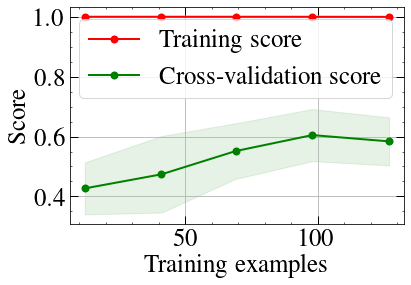

In [117]:
from sklearn.model_selection import ShuffleSplit

regressor, direction, sign = 'gb', 'south', 'S'
parameters = pd.read_csv('params_{0}_{1}.csv'.format(regressor,direction))
df_params = parameters[parameters.rmse == min(parameters.rmse)]

best = df_params[df_params.rmse == min(df_params.rmse)]

params = {}
if regressor == 'gb':
    params['n_estimators'] = best['n_estimators'].values[0]
    params['max_depth'] = best['max_depth'].values[0]
    params['learning_rate'] = best['learning_rate'].values[0]
    params['random_state'] = 0
    params['loss'] = 'ls'

    model = GradientBoostingRegressor(**params)

elif regressor == 'rf':
    params['n_estimators'] = best['n_estimators'].values[0]
    params['max_depth'] = best['max_depth'].values[0]
    params['random_state'] = 0

    model = RandomForestRegressor(**params)

elif regressor == 'sv':
    params['kernel'] = 'rbf'
    params['gamma'] = best['gamma'].values[0]
    params['C'] = best['C'].values[0]
    params['epsilon'] = best['epsilon'].values[0]

    model = SVR(**params)

if sign == 'N':
    bounding = 'north'
    speed_truth = speed_north
else:
    bounding = 'south'
    speed_truth = speed_south

dataset = pd.read_csv('dataset_{}.csv'.format(bounding))
selected = dataset[dataset.truth > 0].reset_index(drop=True)

means = selected.mean()
stdvar = selected.std()
zscored = (selected - means)/stdvar

X = zscored.iloc[:,:-2].reset_index(drop=True)
y = np.array(selected.iloc[:,-2])

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
plot_learning_curve(model, '', X, y, cv=cv, n_jobs=2)